In [1]:
import os

import pandas as pd
import numpy as np

from tqdm import tqdm

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

from sklearn.preprocessing import MinMaxScaler

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from natsort import natsorted

In [2]:
# plt.style.use('dark_background')

matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams['savefig.dpi'] = 600
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

from IPython.core.display import HTML
HTML("""
<style>
.jp-RenderedImage {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
df = pd.read_csv('data/AirPassengers.csv')
df['Month'] = pd.to_datetime(df['Month'], infer_datetime_format=True)
df = df.set_index(['Month'])
df

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [5]:
dates = pd.date_range(start='1949-01-01', freq='MS',periods=len(df))
dates

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', length=144, freq='MS')

In [6]:
df['Month'] = dates.month
df['Year'] = dates.year
df

,#Passengers,Month,Year
Month,,,
1949-01-01,112,1,1949
1949-02-01,118,2,1949
1949-03-01,132,3,1949
1949-04-01,129,4,1949
1949-05-01,121,5,1949
...,...,...,...
1960-08-01,606,8,1960
1960-09-01,508,9,1960
1960-10-01,461,10,1960


In [7]:
X = df['#Passengers'].to_numpy()[:, None]
X.shape

(144, 1)

In [8]:
X.min(), X.max()

(104, 622)

In [9]:
sc = MinMaxScaler()
X = sc.fit_transform(X)

In [10]:
X.min(), X.max()

(0.0, 1.0)

In [11]:
train_size = int(len(X) * 0.70)
test_size = len(X) - train_size
train_data = X[0:train_size,:]
test_data = X[train_size:len(df),:]
print("train size: {}, test size: {} ".format(len(train_data), len(test_data)))

train size: 100, test size: 44 


NameError: name 'x_values' is not defined

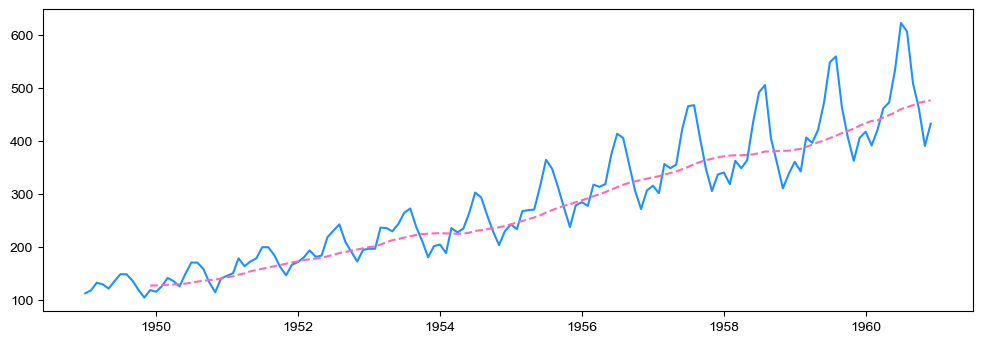

In [12]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df['#Passengers'], color='dodgerblue', label='data')
rolmean = df['#Passengers'].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
mean = ax.plot(rolmean, '--', color='hotpink', label='MA = 12')
ax.axvline(x=x_values[train_size], c='gray', linestyle='--', label='beginning of test samples')
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.legend(frameon=False)
fig.savefig('reports/airpassengers-data.pdf', bbox_inches='tight')

In [ ]:
def prepare_sequence(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

seq_length = 12
x, y = prepare_sequence(X, seq_length)

train_size = int(len(y) * 0.7)
test_size = len(y) - train_size

dataX = torch.Tensor(np.array(x)).to(device).float()
dataY = torch.Tensor(np.array(y)).to(device).float()

trainX = torch.Tensor(np.array(x[0:train_size])).to(device).float()
trainY = torch.Tensor(np.array(y[0:train_size])).to(device).float()

testX = torch.Tensor(np.array(x[train_size:len(x)])).to(device).float()
testY = torch.Tensor(np.array(y[train_size:len(y)])).to(device).float()

In [ ]:
print('shape of dataX: ', dataX.shape)
print('shape of trainX: ', trainX.shape)
print('shape of testX: ', testX.shape)

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, nonlinearity='tanh'):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,   # (batch, time_step, input_size)
            nonlinearity=nonlinearity,
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x (batch, time_step, input_size)
        # hidden state = (n_layers, batch, hidden_size)
        # output = (batch, time_step, hidden_size)
        
        h_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        output, h_n = self.rnn(x, h_0)
        h_n = h_n.view(-1, self.hidden_size)
        out = self.fc(h_n)
        
        return out

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,   # (batch, time_step, input_size)
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x (batch, time_step, input_size)
        # hidden state = (n_layers, batch, hidden_size)
        # output = (batch, time_step, hidden_size)
        
        h_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        
        return out

In [ ]:
hidden_size = 20
architecture = 'RNN' # 'LSTM'
nonlinearity = 'relu'

In [ ]:
if architecture == 'RNN':
    model = RNN(input_size=1, hidden_size=hidden_size, output_size=1, nonlinearity=nonlinearity).to(device) # 12
elif architecture == 'LSTM':
    model = LSTM(input_size=1, hidden_size=hidden_size, output_size=1).to(device) # 20
else:
    raise Error('invalid architecture')

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
for hidden_size in [1, 2, 3, 4, 5, 8, 12, 20]:
    print(hidden_size, '&', end=' ')
    for architecture in ('RNN', 'LSTM'):
        if architecture == 'RNN':
            model = RNN(input_size=1, hidden_size=hidden_size, output_size=1).to(device) # 12
        elif architecture == 'LSTM':
            model = LSTM(input_size=1, hidden_size=hidden_size, output_size=1).to(device) # 20
        else:
            raise Error('invalid architecture')
        print(count_parameters(model), '&', end='')
    print(r'\\')

In [ ]:
def get_grads(model):
    grads = []
    for param in model.parameters():
        grads.append(param.grad.view(-1))
    grads = torch.cat(grads)
    return grads

In [ ]:
model.parameters

In [ ]:
learning_rate = 1e-3
num_epochs = 400

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
gradients = {'min': [], 'max': [], 'mean': [], 'abs': []}
for epoch in range(num_epochs):
    model.train()
    outputs = model(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    gradient = get_grads(model)
    min_grad, max_grad = torch.min(gradient), torch.max(gradient)
    mean_grad = torch.mean(torch.abs(gradient))
    abs_grad = torch.max(torch.abs(gradient))
    gradients['min'].append(min_grad.item())
    gradients['max'].append(max_grad.item())
    gradients['mean'].append(mean_grad.item())
    gradients['abs'].append(abs_grad.item())
    
    model.eval()
    outputs = model(testX)
    val_loss = criterion(outputs, testY)
    val_losses.append(val_loss.item())
    
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(train_losses, color='dodgerblue', label='training')
ax.plot(val_losses, color='hotpink', label='validation')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)

In [ ]:
# relu
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(train_losses, color='dodgerblue', label='training')
ax.plot(val_losses, color='hotpink', label='validation')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)

In [ ]:
history_gradients = {}

In [ ]:
history_gradients[nonlinearity] = gradients.copy()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

for k in history_gradients:
    grads = history_gradients[k]
    # ax.plot(grads['min'], color='#9dd63a', label='min')
    # ax.plot(grads['max'], color='#f426b5', label='max')
    ax.plot(grads['mean'], lw=2.0, label=f'mean(abs) {k}')
#     ax.plot(grads['abs'], label=f'max(abs) {k}')

# ax.axhline(y=0, color='gray', linestyle='--', alpha=0.4)

ax.set_xlim(-1, epoch+1)
ax.set_ylim(0)

ax.set_xlabel('Epoch')
ax.set_ylabel('Gradient magnitude')
ax.legend(frameon=False)
# fig.savefig('reports/airpassengers-rnn-tanh-gradient.pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
# ax.plot(gradients['min'], color='#9dd63a', label='min')
# ax.plot(gradients['max'], color='#f426b5', label='max')
ax.plot(gradients['mean'], color='dodgerblue', label='max(mean)')
# ax.plot(gradients['abs'], color='darkorange', label='max(abs)')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.4)

ax.set_xlabel('Epoch')
ax.set_ylabel('Gradient magnitude')
ax.legend(frameon=False)
# fig.savefig('reports/airpassengers-rnn-tanh-gradient.pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(gradients['min'], color='#9dd63a', label='min')
ax.plot(gradients['max'], color='#f426b5', label='max')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.4)

ax.set_xlabel('Epoch')
ax.set_ylabel('Gradient magnitude')
ax.legend(frameon=False)
fig.savefig('reports/airpassengers-rnn-tanh-gradient.pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(gradients['min'], color='#9dd63a', label='min')
ax.plot(gradients['max'], color='#f426b5', label='max')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.4)

ax.set_xlabel('Epoch')
ax.set_ylabel('Gradient magnitude')
ax.legend(frameon=False)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(gradients['min'], color='#9dd63a', label='min')
ax.plot(gradients['max'], color='#f426b5', label='max')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.4)

ax.set_xlabel('Epoch')
ax.set_ylabel('Gradient magnitude')
ax.legend(frameon=False)

In [ ]:
predictions = {}

In [ ]:
model.eval()
train_predict = model(dataX)

data_predict = train_predict.detach().cpu().numpy()
dataY_plot = dataY.detach().cpu().numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

fig, ax = plt.subplots(figsize=(12, 4))
ax.axvline(x=train_size, c='gray', linestyle='--')

ax.plot(dataY_plot, color='dodgerblue', label='data')
ax.plot(data_predict, color='darkorange', label='prediction')
# ax.set_xticks(xticks)
ax.set_title('')
ax.legend(frameon=False)
# fig.savefig('reports/airpassengers-prediction.pdf', bbox_inches='tight')
plt.show()

In [ ]:
predictions[f'LSTM {hidden_size} hidden neurons'] = data_predict.copy()

[-8036. -7305. -6575. -5844. -5114. -4383. -3653.]


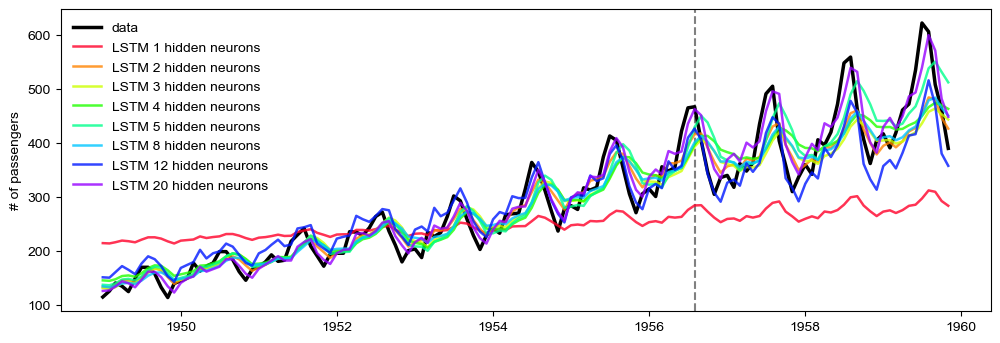

In [320]:
dataY_plot = dataY.detach().cpu().numpy()
dataY_plot = sc.inverse_transform(dataY_plot)

fig, ax = plt.subplots(figsize=(12, 4))
ax.axvline(x=x_values[train_size], c='gray', linestyle='--')

x_values = df['#Passengers'].index.to_numpy()[:-seq_length-1]
ax.plot(x_values, dataY_plot, color='black', lw=2.5, label='data')

NUM_COLORS = len(predictions)
cm = plt.get_cmap('gist_rainbow')
ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
for p in natsorted(predictions):
    ax.plot(x_values, predictions[p], lw=1.8, alpha=0.8, label=p)
    
# ymin, ymax = ax.get_ylim()
# ax.fill_between(np.arange(x_values[train_size], x_values[train_size+test_size]), ymin, ymax, color='orange', alpha=0.1)
# ax.set_ylim(ymin, ymax)
# ax.set_xlim(0, len(dataY_plot)-1)

print(ax.get_xticks())
# ax.set_xticks(xticks)
ax.set_xlabel('')
ax.set_ylabel('# of passengers')
ax.set_title('')
ax.legend(frameon=False)
fig.savefig('reports/airpassengers-lstm-prediction.pdf', bbox_inches='tight')
plt.show()

# Experiment Loop

In [379]:
histories = {}

In [380]:
predictions = {}

In [246]:
# bak_histories = histories.copy()
# bak_predictions = predictions.copy()

In [383]:
architecture = 'RNN'
nonlinearity = 'relu'

for hidden_size in [1, 2, 3, 4, 5, 8, 12, 20]:
    print(architecture, hidden_size)
    del model
    if architecture == 'RNN':
        model = RNN(input_size=1, hidden_size=hidden_size, output_size=1, nonlinearity=nonlinearity).to(device) # 12
    elif architecture == 'LSTM':
        model = LSTM(input_size=1, hidden_size=hidden_size, output_size=1).to(device) # 20
    else:
        raise Error('invalid architecture')

    learning_rate = 1e-2
    num_epochs = 200

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    gradients = {'min': [], 'max': []}
    for epoch in range(num_epochs):
        model.train()
        outputs = model(trainX)
        optimizer.zero_grad()
        loss = criterion(outputs, trainY)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        min_grad, max_grad = torch.min(get_grads(model)), torch.max(get_grads(model))
        gradients['min'].append(min_grad.item())
        gradients['max'].append(max_grad.item())

        model.eval()
        outputs = model(testX)
        val_loss = criterion(outputs, testY)
        val_losses.append(val_loss.item())

        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
            
            
    histories[f'{architecture} {hidden_size} hidden neurons'] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'error': val_loss.item()
    }
    
    model.eval()
    train_predict = model(dataX)

    data_predict = train_predict.detach().cpu().numpy()
    dataY_plot = dataY.detach().cpu().numpy()

    data_predict = sc.inverse_transform(data_predict)
    dataY_plot = sc.inverse_transform(dataY_plot)
    
    predictions[f'{architecture} {hidden_size} hidden neurons'] = data_predict.copy()

RNN 1
Epoch: 0, loss: 0.03097
Epoch: 100, loss: 0.02179
RNN 2
Epoch: 0, loss: 0.15079
Epoch: 100, loss: 0.01672
RNN 3
Epoch: 0, loss: 1.37021
Epoch: 100, loss: 0.03383
RNN 4
Epoch: 0, loss: 0.31430
Epoch: 100, loss: 0.02062
RNN 5
Epoch: 0, loss: 0.58126
Epoch: 100, loss: 0.00332
RNN 8
Epoch: 0, loss: 0.06466
Epoch: 100, loss: 0.00383
RNN 12
Epoch: 0, loss: 0.02401
Epoch: 100, loss: 0.00266
RNN 20
Epoch: 0, loss: 0.02340
Epoch: 100, loss: 0.00271


In [382]:
# tanh
for k in histories:
    print(k, '&',  f"{histories[k]['error']:.4f}", r'\\')

RNN 1 hidden neurons & 0.1022 \\
RNN 2 hidden neurons & 0.0107 \\
RNN 3 hidden neurons & 0.0120 \\
RNN 4 hidden neurons & 0.0128 \\
RNN 5 hidden neurons & 0.0073 \\
RNN 8 hidden neurons & 0.0102 \\
RNN 12 hidden neurons & 0.0067 \\
RNN 20 hidden neurons & 0.0071 \\


In [384]:
# relu
for k in histories:
    print(k, '&',  f"{histories[k]['error']:.4f}", r'\\')

RNN 1 hidden neurons & 0.1501 \\
RNN 2 hidden neurons & 0.0195 \\
RNN 3 hidden neurons & 0.1515 \\
RNN 4 hidden neurons & 0.1114 \\
RNN 5 hidden neurons & 0.0118 \\
RNN 8 hidden neurons & 0.0249 \\
RNN 12 hidden neurons & 0.0094 \\
RNN 20 hidden neurons & 0.0072 \\


In [178]:
for k in histories:
    print(k, '&',  f"{histories[k]['error']:.4f}", r'\\')

1 & 0.1502 \\
2 & 0.1540 \\
3 & 0.0123 \\
4 & 0.0117 \\
5 & 0.0109 \\
8 & 0.0125 \\
12 & 0.0131 \\
20 & 0.0086 \\


In [225]:
for k in histories:
    print(k, '&',  f"{histories[k]['error']:.4f}", r'\\')

1 & 0.1473 \\
2 & 0.0103 \\
3 & 0.0169 \\
4 & 0.0066 \\
5 & 0.0069 \\
8 & 0.0093 \\
12 & 0.0041 \\
20 & 0.0073 \\


[-8036. -7305. -6575. -5844. -5114. -4383. -3653.]


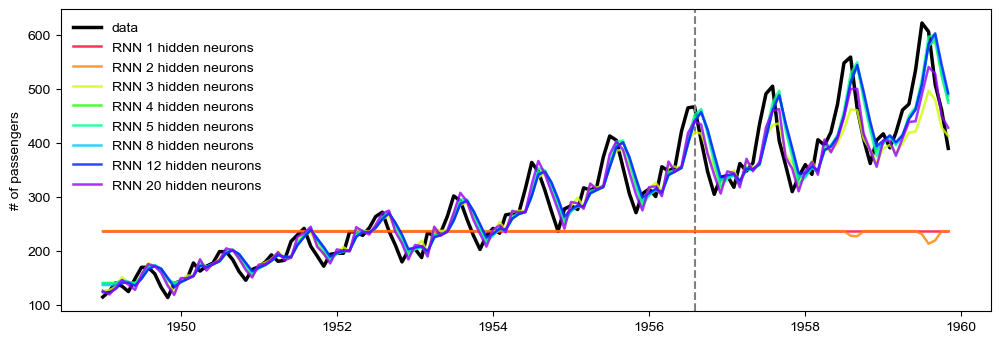

In [234]:
dataY_plot = dataY.detach().cpu().numpy()
dataY_plot = sc.inverse_transform(dataY_plot)

fig, ax = plt.subplots(figsize=(12, 4))

x_values = df['#Passengers'].index.to_numpy()[:-seq_length-1]
ax.plot(x_values, dataY_plot, color='black', lw=2.5, label='data')

ax.axvline(x=x_values[train_size], c='gray', linestyle='--')

rnn_predictions = [k for k in list(predictions) if 'RNN' in k ]
NUM_COLORS = len(rnn_predictions)
cm = plt.get_cmap('gist_rainbow')
ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
for p in natsorted(rnn_predictions):
    ax.plot(x_values, predictions[p], lw=1.8, alpha=0.8, label=p)
    
# ymin, ymax = ax.get_ylim()
# ax.fill_between(np.arange(x_values[train_size], x_values[train_size+test_size]), ymin, ymax, color='orange', alpha=0.1)
# ax.set_ylim(ymin, ymax)
# ax.set_xlim(0, len(dataY_plot)-1)

print(ax.get_xticks())
# ax.set_xticks(xticks)
ax.set_xlabel('')
ax.set_ylabel('# of passengers')
ax.set_title('')
ax.legend(frameon=False)
fig.savefig(f'reports/airpassengers-prediction-RNN.pdf', bbox_inches='tight')
plt.show()

[-8036. -7305. -6575. -5844. -5114. -4383. -3653.]


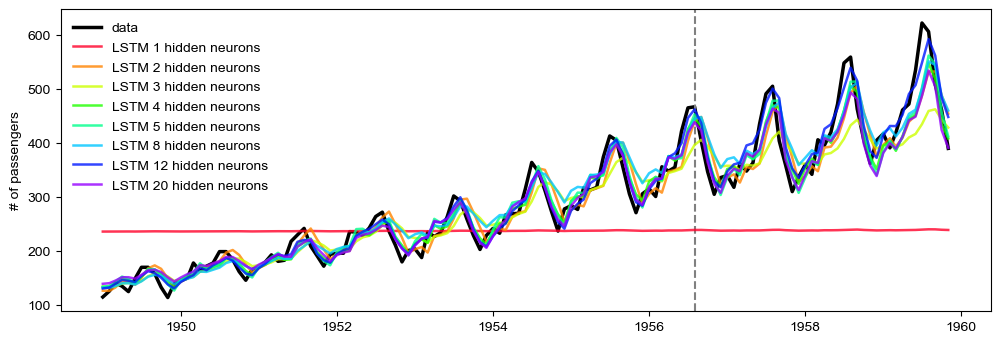

In [233]:
dataY_plot = dataY.detach().cpu().numpy()
dataY_plot = sc.inverse_transform(dataY_plot)

fig, ax = plt.subplots(figsize=(12, 4))

x_values = df['#Passengers'].index.to_numpy()[:-seq_length-1]
ax.plot(x_values, dataY_plot, color='black', lw=2.5, label='data')

ax.axvline(x=x_values[train_size], c='gray', linestyle='--')

lstm_predictions = [k for k in list(predictions) if 'LSTM' in k ]
NUM_COLORS = len(lstm_predictions)
cm = plt.get_cmap('gist_rainbow')
ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
for p in natsorted(lstm_predictions):
    ax.plot(x_values, predictions[p], lw=1.8, alpha=0.8, label=p)
    
# ymin, ymax = ax.get_ylim()
# ax.fill_between(np.arange(x_values[train_size], x_values[train_size+test_size]), ymin, ymax, color='orange', alpha=0.1)
# ax.set_ylim(ymin, ymax)
# ax.set_xlim(0, len(dataY_plot)-1)

print(ax.get_xticks())
# ax.set_xticks(xticks)
ax.set_xlabel('')
ax.set_ylabel('# of passengers')
ax.set_title('')
ax.legend(frameon=False)
fig.savefig(f'reports/airpassengers-prediction-LSTM.pdf', bbox_inches='tight')
plt.show()

[-8036. -7305. -6575. -5844. -5114. -4383. -3653.]


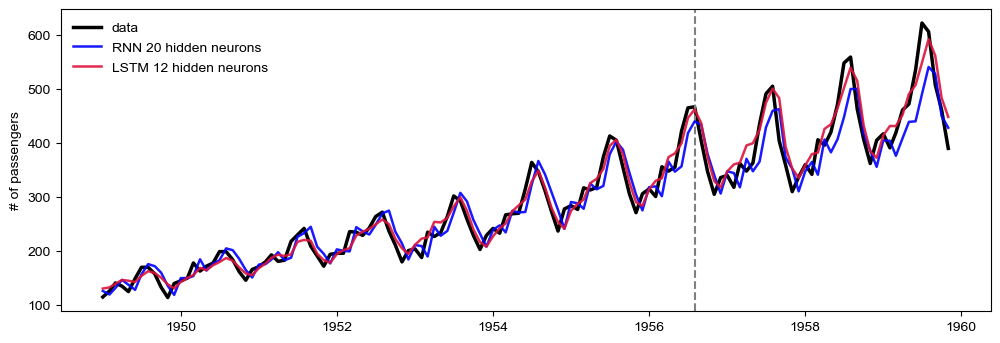

In [232]:
dataY_plot = dataY.detach().cpu().numpy()
dataY_plot = sc.inverse_transform(dataY_plot)

fig, ax = plt.subplots(figsize=(12, 4))

x_values = df['#Passengers'].index.to_numpy()[:-seq_length-1]
ax.plot(x_values, dataY_plot, color='black', lw=2.5, label='data')

ax.axvline(x=x_values[train_size], c='gray', linestyle='--')

k = 'RNN 20 hidden neurons'
ax.plot(x_values, predictions[k], lw=1.8, alpha=0.9, label=k, color='blue')
k = 'LSTM 12 hidden neurons'
ax.plot(x_values, predictions[k], lw=1.8, alpha=0.9, label=k, color='crimson')

print(ax.get_xticks())
ax.set_xlabel('')
ax.set_ylabel('# of passengers')
ax.set_title('')
ax.legend(frameon=False)
fig.savefig(f'reports/airpassengers-prediction-RNN_LSTM-bests.pdf', bbox_inches='tight')
plt.show()

# Varying learning rate

In [286]:
num_epochs = 300
hidden_size = 12
architecture = 'LSTM' # 'LSTM'

learning_curves = {}
for learning_rate in (1e-1, 1e-2, 1e-3, 1e-4):
    if architecture == 'RNN':
        model = RNN(input_size=1, hidden_size=hidden_size, output_size=1).to(device) # 12
    elif architecture == 'LSTM':
        model = LSTM(input_size=1, hidden_size=hidden_size, output_size=1).to(device) # 20
    else:
        raise Error('invalid architecture')
    
    criterion = torch.nn.MSELoss()
    # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    gradients = {'min': [], 'max': []}
    for epoch in range(num_epochs):
        model.train()
        outputs = model(trainX)
        optimizer.zero_grad()
        loss = criterion(outputs, trainY)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        min_grad, max_grad = torch.min(get_grads(model)), torch.max(get_grads(model))
        gradients['min'].append(min_grad.item())
        gradients['max'].append(max_grad.item())

        model.eval()
        outputs = model(testX)
        val_loss = criterion(outputs, testY)
        val_losses.append(val_loss.item())

        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
    learning_curves[learning_rate] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'error': val_loss.item()
    }

Epoch: 0, loss: 0.04955
Epoch: 100, loss: 0.01927
Epoch: 200, loss: 0.01753
Epoch: 0, loss: 0.02246
Epoch: 100, loss: 0.02160
Epoch: 200, loss: 0.02135
Epoch: 0, loss: 0.03475
Epoch: 100, loss: 0.03118
Epoch: 200, loss: 0.02907
Epoch: 0, loss: 0.21633
Epoch: 100, loss: 0.20593
Epoch: 200, loss: 0.19608


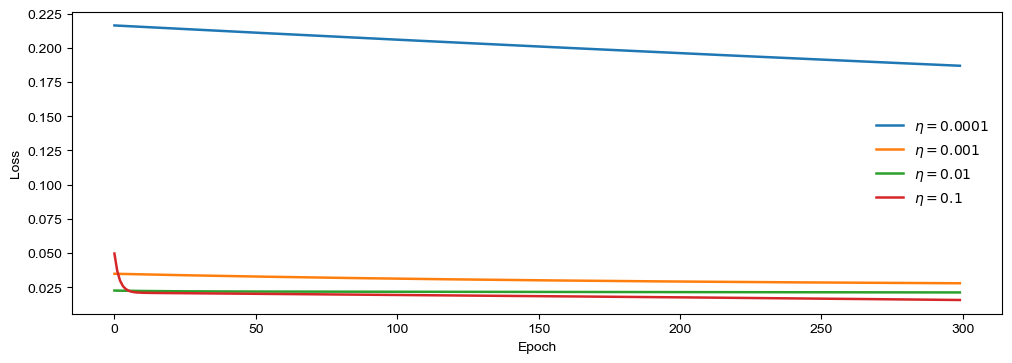

In [291]:
fig, ax = plt.subplots(figsize=(12, 4))
for k in natsorted(learning_curves):
    ax.plot(learning_curves[k]['train_losses'], lw=1.8, label=f'$\eta={k}$')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
fig.savefig('reports/airpassengers-train-learning_rate.pdf', bbox_inches='tight')

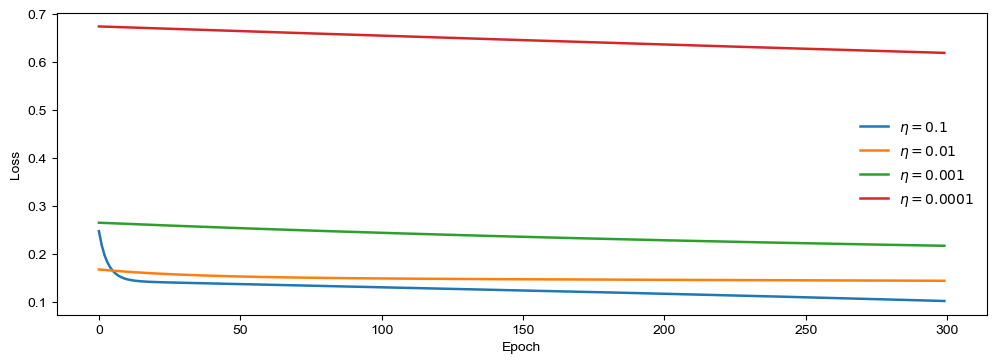

In [292]:
fig, ax = plt.subplots(figsize=(12, 4))
for k in learning_curves:
#     ax.plot(learning_curves[k]['train_losses'], color='dodgerblue', label=f'$\eta={k}$')
    ax.plot(learning_curves[k]['val_losses'], lw=1.8, label=f'$\eta={k}$')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
fig.savefig('reports/airpassengers-validation-learning_rate.pdf', bbox_inches='tight')